<h1> SMPP - STOCK MARKET PRICE PREDICTION</h1>
<p>Maded by: Murat EFE<br/>
<a href='https://www.linkedin.com/in/murratefe'>My Linkedin</a>
</p>

<h1 style='color:red;'>IMPORTANT NOTICE!</h1><br/>
<p>This model is highly experimantal and too risky for use real world investment <b>do not use this model any real investment.<b/><br/>
<b>We are not responsible for any outcomes that may arise from the use of this model for any real investment purposes.</b></p>


In [ ]:
!pip install yfinance
!pip install pandas
!pip install pandas-ta
!pip install numpy
!pip install seaborn
!pip install matplotlib
!pip install scikit-learn
!pip install shap
!pip install cloudpickle

Importing libraries

In [2]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

Creating functions for get stock data and augmentation stock data

In [3]:
def get_stock_data(symbol:str ,end:str, start:str="", period:str="max", interval:str="1d") -> pd.DataFrame():
    if start == "":
        data = yf.download(symbol.upper(), period=period.lower(), end=end, interval=interval, auto_adjust=True)  
    else:
        data = yf.download(symbol.upper(), period=period.lower(), start=start, end=end, interval=interval, auto_adjust=True)
    data.reset_index(inplace=True)
    return data

In [4]:
def expand_data(datas):
    datas["Date"] = pd.to_datetime(datas["Date"] ,format='%d/%m/%Y %H:%M:%S')

    
    datas['Support'] = datas['Low'].rolling(window=7).min()
    datas['Resistance'] = datas['High'].rolling(window=7).max()
    
    datas["SMA7"] = datas["Close"].rolling(window=7).mean()
    datas["SMA9"] = datas["Close"].rolling(window=9).mean()
    datas["SMA12"] = datas["Close"].rolling(window=12).mean()
    datas["SMA21"] = datas["Close"].rolling(window=21).mean()
    datas["SMA24"] = datas["Close"].rolling(window=24).mean()
    datas["SMA26"] = datas["Close"].rolling(window=26).mean()
    datas["SMA50"] = datas["Close"].rolling(window=50).mean()
    
    datas["Daily Change"] = datas["Close"].pct_change() * 100
    
    weights_9 = list(range(1,10))    
    weights_12 = list(range(1,13))  
    
    datas["WMA9"] = datas["Close"].rolling(window=9).apply(lambda prices: sum(prices * weights_9) / sum(weights_9), raw=True)
    datas["WMA12"] = datas["Close"].rolling(window=12).apply(lambda prices: sum(prices * weights_12) / sum(weights_12), raw=True)
    
    datas["EMA7"] = datas["Close"].ewm(span=7, adjust=True).mean()
    datas["EMA9"] = datas["Close"].ewm(span=9, adjust=True).mean()
    datas["EMA12"] = datas["Close"].ewm(span=12, adjust=True).mean()
    datas["EMA21"] = datas["Close"].ewm(span=21, adjust=True).mean()
    datas["EMA26"] = datas["Close"].ewm(span=26, adjust=True).mean()
    
    datas["MACD"] = datas["EMA12"] - datas["EMA26"]
    datas["MACD Signal"] = datas["MACD"].ewm(span=9, adjust=True).mean()
    datas["RSI"] = ta.rsi(datas["Close"], length=14)
    bbands_data = ta.bbands(datas["Close"], length=20)
    datas["Bollinger Bands Upper"] = bbands_data["BBU_20_2.0"]
    datas["Bollinger Bands Lower"] = bbands_data["BBL_20_2.0"]
    datas["Bollinger Bands Middle"] = bbands_data["BBM_20_2.0"]
    datas["Target Close"] = datas["Close"].shift(-1) #The Target Close is the closing price of the stock on the following day, n+1 day.
    return datas

Exploratory data analysis in a sample of data

In [5]:
sample = get_stock_data("GOOGL",end="2023-12-12")
sample

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Volume
0,2004-08-19,2.502503,2.604104,2.401401,2.511011,893181924
1,2004-08-20,2.527778,2.729730,2.515015,2.710460,456686856
2,2004-08-23,2.771522,2.839840,2.728979,2.737738,365122512
3,2004-08-24,2.783784,2.792793,2.591842,2.624374,304946748
4,2004-08-25,2.626627,2.702703,2.599600,2.652653,183772044
...,...,...,...,...,...,...
4857,2023-12-05,128.949997,132.139999,128.250000,130.990005,27384800
4858,2023-12-06,131.440002,131.839996,129.880005,130.020004,23576200
4859,2023-12-07,135.039993,138.559998,134.699997,136.929993,56767100
4860,2023-12-08,134.199997,136.399994,134.029999,134.990005,32233900


In [6]:
sample.dtypes

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume             int64
dtype: object

In [7]:
sample.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [8]:
#Lets expand our data
sample = expand_data(sample)

In [9]:
sample.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Support',
       'Resistance', 'SMA7', 'SMA9', 'SMA12', 'SMA21', 'SMA24', 'SMA26',
       'SMA50', 'Daily Change', 'WMA9', 'WMA12', 'EMA7', 'EMA9', 'EMA12',
       'EMA21', 'EMA26', 'MACD', 'MACD Signal', 'RSI', 'Bollinger Bands Upper',
       'Bollinger Bands Lower', 'Bollinger Bands Middle', 'Target Close'],
      dtype='object')

In [10]:
sample.dtypes

Date                      datetime64[ns]
Open                             float64
High                             float64
Low                              float64
Close                            float64
Volume                             int64
Support                          float64
Resistance                       float64
SMA7                             float64
SMA9                             float64
SMA12                            float64
SMA21                            float64
SMA24                            float64
SMA26                            float64
SMA50                            float64
Daily Change                     float64
WMA9                             float64
WMA12                            float64
EMA7                             float64
EMA9                             float64
EMA12                            float64
EMA21                            float64
EMA26                            float64
MACD                             float64
MACD Signal     

Let's Visualize Our Dataset

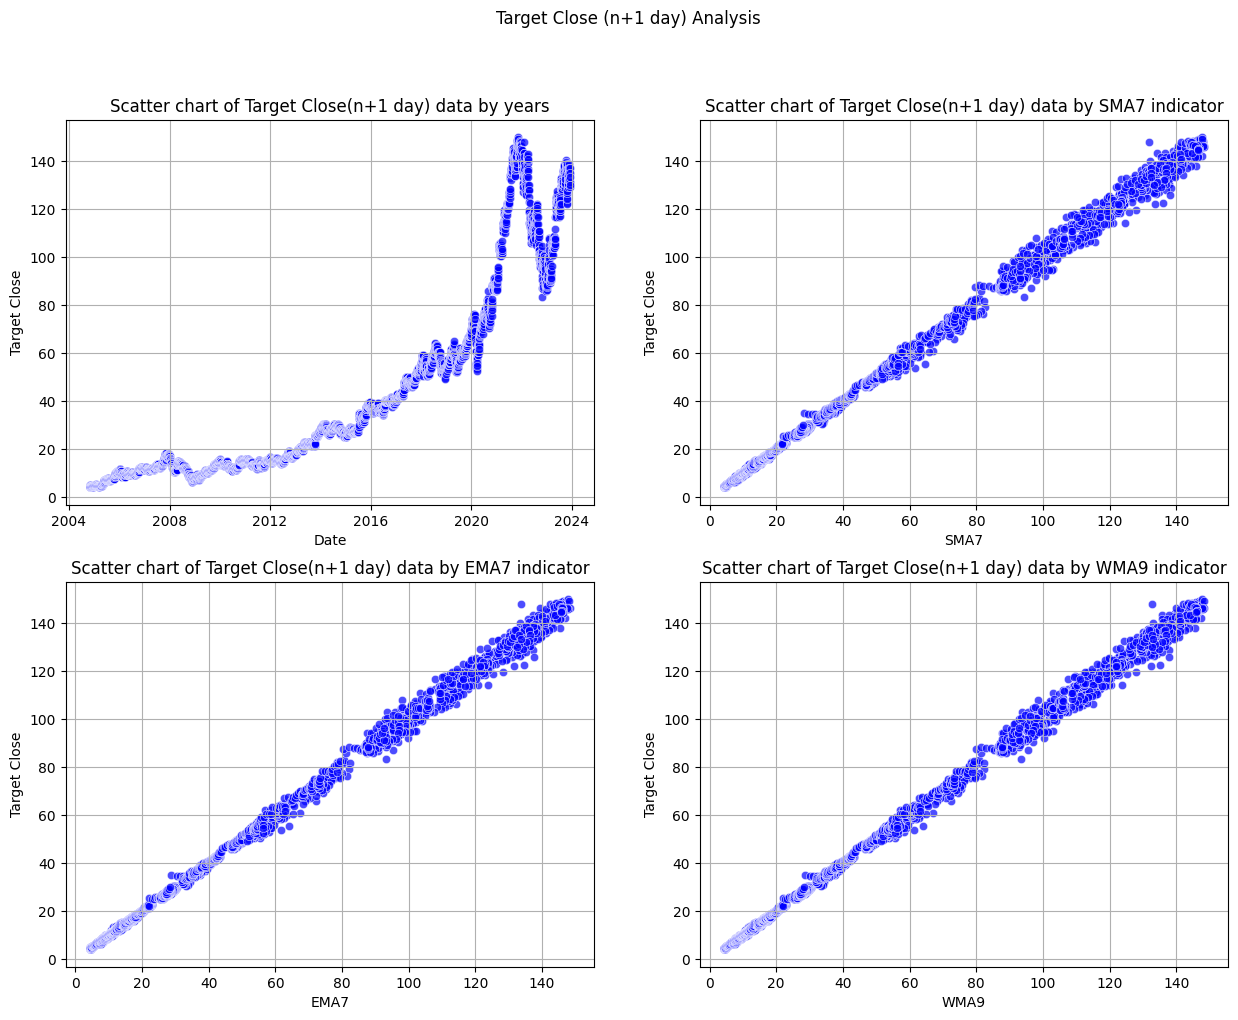

In [11]:
sample = sample.dropna() #First things first drop the null cells

fig, axs = plt.subplots(2,2, figsize=(15,11))

fig.suptitle("Target Close (n+1 day) Analysis")

sns.scatterplot(
    x="Date",
    y="Target Close",
    alpha=0.7,
    color='blue',
    data=sample,
    ax=axs[0,0]
) #Visualizing Target Close data by Years

sns.scatterplot(
    x="SMA7",
    y="Target Close",
    alpha=0.7,
    color='blue',
    data=sample,
    ax=axs[0,1]
) #Visualizing Target Close data by SMA7

sns.scatterplot(
    x="EMA7",
    y="Target Close",
    alpha=0.7,
    color='blue',
    data=sample,
    ax=axs[1,0]
) #Visualizing Target Close data by EMA7

sns.scatterplot(
    x="WMA9",
    y="Target Close",
    alpha=0.7,
    color='blue',
    data=sample,
    ax=axs[1,1]
)#Visualizing Target Close data by WMA9


axs[0,0].set_title("Scatter chart of Target Close(n+1 day) data by years")
axs[0,1].set_title("Scatter chart of Target Close(n+1 day) data by SMA7 indicator")
axs[1,0].set_title("Scatter chart of Target Close(n+1 day) data by EMA7 indicator")
axs[1,1].set_title("Scatter chart of Target Close(n+1 day) data by WMA9 indicator")

axs[0,0].grid(True)
axs[0,1].grid(True)
axs[1,0].grid(True)
axs[1,1].grid(True)



plt.savefig("scatter_charts_for_apple.png")
plt.show()

 # ![Time Series patterns](https://miro.medium.com/v2/resize:fit:1276/1*xYwv3xjv1sdq4rPUlzRarA.jpeg)


As the graph shows, we are dropping time data from data table.

Let's Build a Data Pipeline


In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

In [13]:
class aug_data(BaseEstimator,TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        """
        You need at least 50+1 days of data to be able to add these indicators., meaning you need 50+1 days of data for the prediction you are going to make.
        """
        X["Date"] = pd.to_datetime(X["Date"] ,format='%d/%m/%Y %H:%M:%S')
    
        X['Support'] = X['Low'].rolling(window=7).min()
        X['Resistance'] = X['High'].rolling(window=7).max()
        X["SMA7"] = X["Close"].rolling(window=7).mean()
        X["SMA9"] = X["Close"].rolling(window=9).mean()
        X["SMA12"] = X["Close"].rolling(window=12).mean()
        X["SMA21"] = X["Close"].rolling(window=21).mean()
        X["SMA24"] = X["Close"].rolling(window=24).mean()
        X["SMA26"] = X["Close"].rolling(window=26).mean()
        X["SMA50"] = X["Close"].rolling(window=50).mean()
    
        X["Daily Change"] = X["Close"].pct_change() * 100
    
        weights_9 = list(range(1,10))    
        weights_12 = list(range(1,13))  
    
        X["WMA9"] = X["Close"].rolling(window=9).apply(lambda prices: sum(prices * weights_9) / sum(weights_9), raw=True)
        X["WMA12"] = X["Close"].rolling(window=12).apply(lambda prices: sum(prices * weights_12) / sum(weights_12), raw=True)
    
        X["EMA7"] = X["Close"].ewm(span=7, adjust=True).mean()
        X["EMA9"] = X["Close"].ewm(span=9, adjust=True).mean()
        X["EMA12"] = X["Close"].ewm(span=12, adjust=True).mean()
        X["EMA21"] = X["Close"].ewm(span=21, adjust=True).mean()
        X["EMA26"] = X["Close"].ewm(span=26, adjust=True).mean()
    
        X["MACD"] = X["EMA12"] - X["EMA26"]
        X["MACD Signal"] = X["MACD"].ewm(span=9, adjust=True).mean()
        X["RSI"] = ta.rsi(X["Close"], length=14)
        bbands_data = ta.bbands(X["Close"], length=20)
        X["Bollinger Bands Upper"] = bbands_data["BBU_20_2.0"]
        X["Bollinger Bands Lower"] = bbands_data["BBL_20_2.0"]
        X["Bollinger Bands Middle"] = bbands_data["BBM_20_2.0"]
        return X

In [14]:
class drop_unnecessary_col(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        return X.drop(columns=['Date'])

In [15]:
class set_label(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        X["Target Close"] = X["Close"].shift(-1) #The Target Close is the closing price of the stock on the following day, n+1 day.
        return X

In [16]:
class drop_null(BaseEstimator,TransformerMixin):
    def fit(self,X,y=None):
        return self
    def transform(self,X):
        return X.dropna()

In [17]:
class set_dtypes(BaseEstimator,TransformerMixin):
    def fit(self,X, y=None):
        return self
    def transform(self, X):
        return X.astype(np.float32)

In [18]:
class scaleData(BaseEstimator,TransformerMixin):
    def fit(self, X, y=None):
        return self
    def transform(self,X):
        scaler = MinMaxScaler(feature_range=(0,1))
        if 'Target Close' in X:
            X_scaled = scaler.fit_transform(X.drop(columns='Target Close'))
            X_scaled = pd.DataFrame(X_scaled, columns=X.drop(columns='Target Close').columns)
            X_scaled['Target Close'] = X['Target Close']
        else:
            X_scaled = scaler.fit_transform(X)
            X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
        return X_scaled

In [19]:
#Building a pipeline for training
pipe = Pipeline([
    ('aug', aug_data()),
    ('drop_unnecessary', drop_unnecessary_col()),
    ('set_label',set_label()),
    ('set_dtype', set_dtypes()),
    ('scaler', scaleData()),
    ('dropper', drop_null()),
])

In [20]:
#Building a pipeline for prediction
pipe_for_pred = Pipeline([
    ('aug', aug_data()),
    ('drop_unnecessary', drop_unnecessary_col()),
    ('set_dtype', set_dtypes()),
    ('scaler', scaleData()),
    ('dropper', drop_null()),
    ])

Let's Create a dataset for APPL stock

In [21]:
dataset = get_stock_data('AAPL', end='2024-05-30', period='max')
dataset = pipe.fit_transform(dataset)

[*********************100%%**********************]  1 of 1 completed


In [22]:
dataset

,Open,High,Low,Close,Volume,Support,Resistance,SMA7,SMA9,SMA12,...,EMA12,EMA21,EMA26,MACD,MACD Signal,RSI,Bollinger Bands Upper,Bollinger Bands Lower,Bollinger Bands Middle,Target Close
49,0.000225,0.000223,0.000224,0.000222,0.002288,0.000228,0.000260,0.000240,0.000241,0.000247,...,0.000247,0.000261,0.000267,0.469101,0.455860,0.215569,0.000302,0.000234,0.000262,0.086999
50,0.000246,0.000247,0.000250,0.000249,0.002626,0.000228,0.000260,0.000240,0.000239,0.000242,...,0.000245,0.000258,0.000264,0.469116,0.455849,0.325723,0.000287,0.000238,0.000256,0.088290
51,0.000253,0.000253,0.000257,0.000255,0.001461,0.000228,0.000260,0.000239,0.000238,0.000240,...,0.000244,0.000256,0.000262,0.469140,0.455845,0.350900,0.000275,0.000241,0.000251,0.091306
52,0.000268,0.000270,0.000272,0.000270,0.001989,0.000228,0.000247,0.000237,0.000240,0.000239,...,0.000246,0.000256,0.000261,0.469179,0.455851,0.407590,0.000266,0.000245,0.000248,0.091737
53,0.000270,0.000270,0.000274,0.000273,0.001585,0.000228,0.000247,0.000239,0.000241,0.000239,...,0.000248,0.000255,0.000260,0.469216,0.455864,0.415568,0.000262,0.000245,0.000247,0.090445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10950,0.967539,0.968021,0.971684,0.973478,0.005701,0.956613,0.968021,0.966574,0.962291,0.956735,...,0.958211,0.947649,0.944427,0.843590,0.779458,0.771812,0.975982,0.867329,0.932887,190.899994
10951,0.973515,0.968474,0.968376,0.966138,0.004669,0.965268,0.968473,0.969941,0.966030,0.960766,...,0.961785,0.951584,0.948182,0.841776,0.797859,0.715524,0.979436,0.875317,0.938593,186.880005
10952,0.966982,0.959330,0.949846,0.945789,0.006873,0.967030,0.968473,0.969540,0.968206,0.962786,...,0.961628,0.953263,0.950107,0.813066,0.806175,0.580499,0.979276,0.884581,0.943037,189.979996
10953,0.956043,0.957221,0.957024,0.961481,0.004890,0.967030,0.968473,0.969729,0.970309,0.965985,...,0.963948,0.956253,0.953086,0.804429,0.810901,0.638361,0.979149,0.895758,0.948433,189.990005


Let's split the data

In [23]:
test = dataset.iloc[-100:] #Last 100 data split for validation
train = dataset.iloc[:-100] 

In [24]:
print(len(train))

10806


In [25]:
#Train Data
X = train.drop(columns='Target Close')
y = train['Target Close']

In [26]:
#Test Data
X_test = test.drop(columns='Target Close')
y_test = test['Target Close']

Building The Model

In [27]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
import shap

In [28]:
model = Ridge()
model.fit(X,y)
print(model.score(X_test,y_test))
print(cross_val_score(model, X_test,y_test, cv=5, scoring='neg_mean_squared_error').mean())

0.8898801408787523
-18.208859252929688


In [29]:
preds = model.predict(X_test)
print('MAE Score: ', mean_absolute_error(y_test, preds))
test['preds'] = preds

MAE Score:  2.1878614


C:\Users\Murat\AppData\Local\Temp\ipykernel_8700\2452929723.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['preds'] = preds


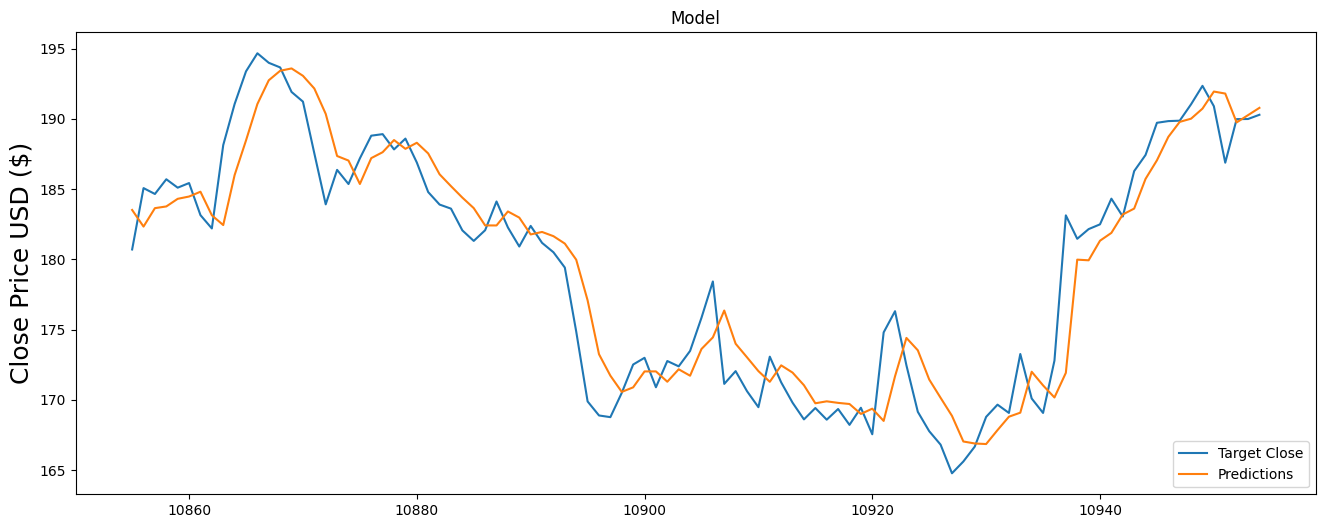

In [30]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(test[['Target Close', 'preds']])
plt.legend(['Target Close', 'Predictions'], loc='lower right')
plt.show()

Explaining Our Model With Shap

In [31]:
ex = shap.KernelExplainer(model.predict, shap.sample(X, 100))

  0%|          | 0/100 [00:00<?, ?it/s]

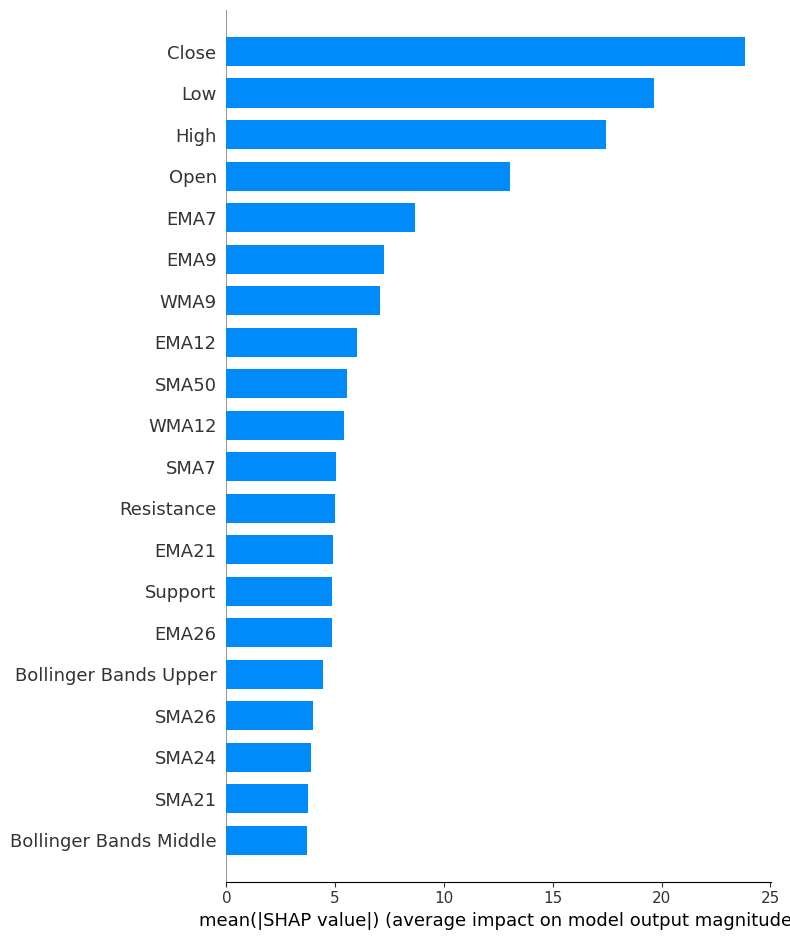

In [32]:
shap_values = ex.shap_values(X_test)
shap.summary_plot(shap_values,X_test, plot_type='bar', show=False)
plt.show()

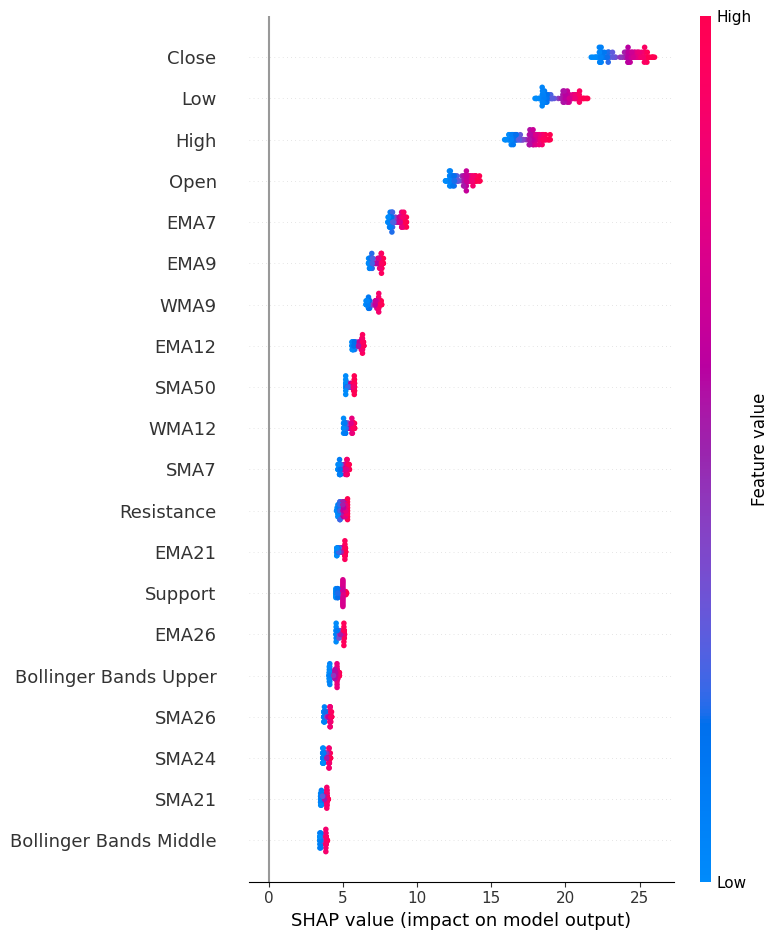

In [33]:
shap.summary_plot(shap_values, X_test, plot_type="dot", show=False)

# Show the plot
plt.show()

In [34]:
shap.initjs()
shap_values = ex.shap_values(X_test.iloc[10,:])
shap.force_plot(ex.expected_value, shap_values, X_test.iloc[10,:])

Hyperparameter search

In [35]:
alpha = []
cv_score = []
model_score = []
mae_score = []
preds = {}
for a in np.arange(0.01,100.00,0.01):
    model = Ridge(alpha=a, random_state=42)
    model.fit(X,y)
    score = model.score(X_test,y_test)
    cv = cross_val_score(model, X_test,y_test, cv=5, scoring="neg_mean_squared_error").mean()
    model_score.append(score)
    cv_score.append(cv)
    alpha.append(a)
    pred = model.predict(X_test)
    preds[a] = pred
    mae = mean_absolute_error(y_test, pred)
    mae_score.append(mae)

In [36]:
print(f'The Best Alpha Number: {alpha[cv_score.index(max(cv_score))]}\n cv score: {max(cv_score)}\n model score: {model_score[cv_score.index(max(cv_score))]}\n MAE: {mae_score[cv_score.index(max(cv_score))]}')

The Best Alpha Number: 0.04
 cv score: -8.71382122039795
 model score: 0.9120292389386958
 MAE: 1.9038935899734497


Build a model with best hyperparameters

In [37]:
best_alpha = alpha[cv_score.index(max(cv_score))]
best_model = Ridge(random_state=42, alpha=best_alpha)
best_model.fit(X,y)
print(model.score(X_test,y_test))
print(cross_val_score(best_model, X_test,y_test, cv=5, scoring='neg_mean_squared_error').mean())

0.7724043935233723
-8.71382122039795


C:\Users\Murat\AppData\Local\Temp\ipykernel_8700\1629788380.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['preds'] = preds[alpha[cv_score.index(max(cv_score))]]


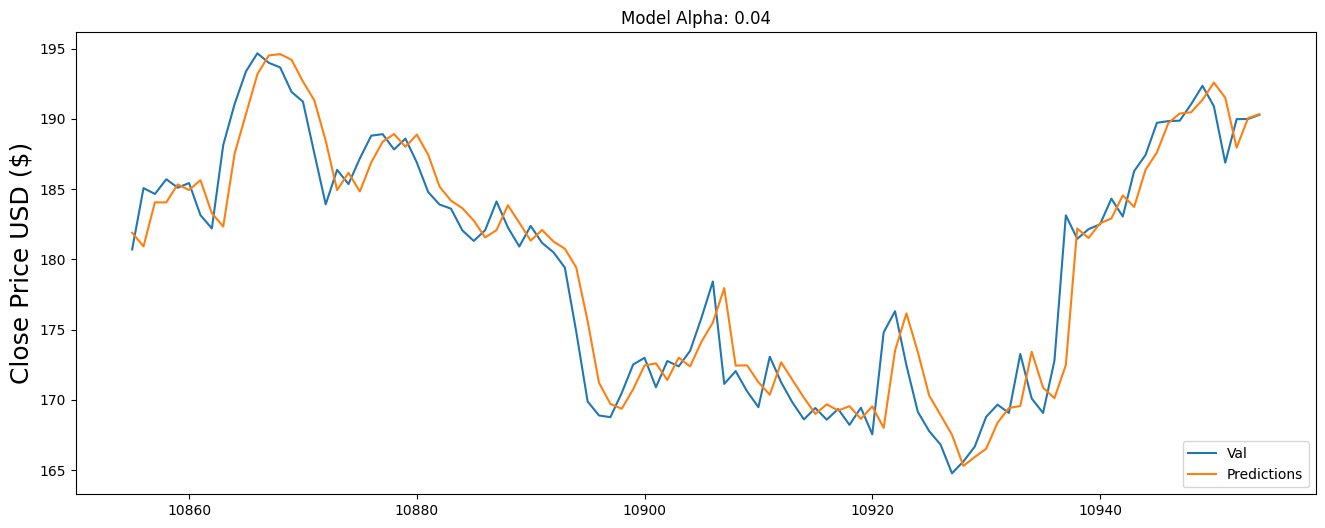

In [38]:
# Visualizing the data
test['preds'] = preds[alpha[cv_score.index(max(cv_score))]]
plt.figure(figsize=(16,6))
plt.title(f'Model Alpha: {alpha[cv_score.index(max(cv_score))]}')
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(test[['Target Close','preds']])
plt.legend(['Val', 'Predictions'], loc='lower right')
plt.show()
plt.close()

Explaining Our Best Model With Shap

In [39]:
ex = shap.KernelExplainer(best_model.predict, shap.sample(X, 100))

  0%|          | 0/100 [00:00<?, ?it/s]

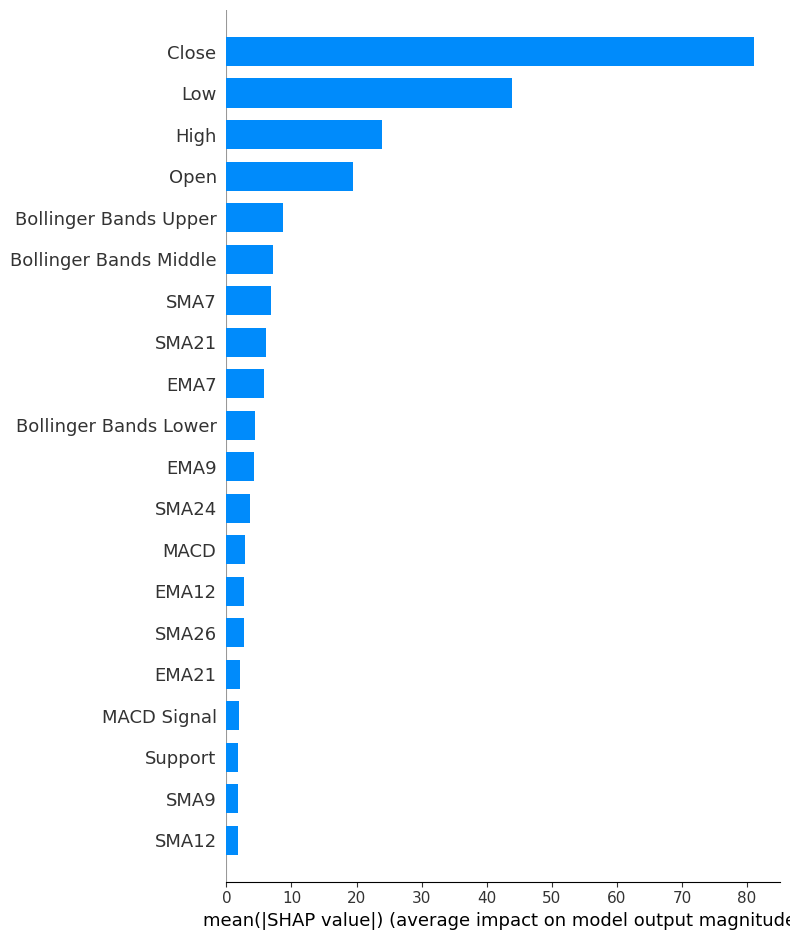

In [40]:
shap_values = ex.shap_values(X_test)
shap.summary_plot(shap_values,X_test, plot_type='bar', show=False)
plt.show()

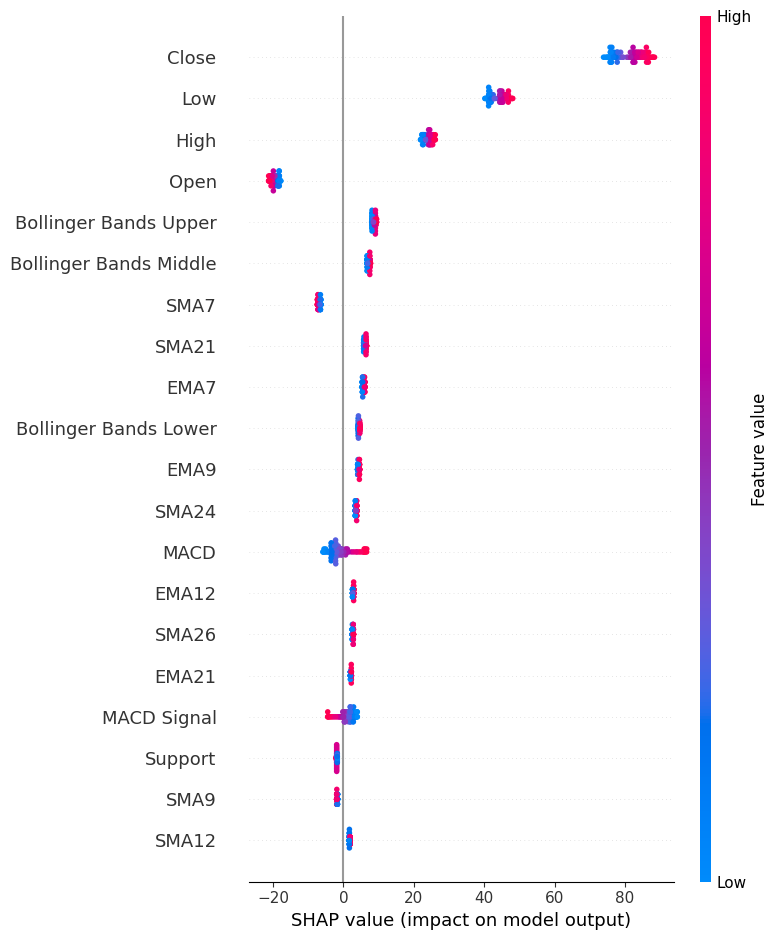

In [41]:
shap.summary_plot(shap_values, X_test, plot_type="dot", show=False)
plt.show()

In [42]:
shap.initjs()
shap_values = ex.shap_values(X_test.iloc[10,:])
shap.force_plot(ex.expected_value, shap_values, X_test.iloc[10,:])

Saving our model

In [43]:
import pickle
import cloudpickle
from datetime import datetime
import os

In [44]:
now = datetime.now().strftime("%Y_%m_%d_%H_%M")
if not os.path.exists(f'models/{now}'):
    os.makedirs(f'models/{now}')

In [45]:
pickle.dump(best_model, open(f'models/{now}/model.pkl','wb'))
cloudpickle.dump(pipe, open(f'models/{now}/pipeline_for_training.pkl','wb'))
cloudpickle.dump(pipe_for_pred, open(f'models/{now}/pipeline_for_predict.pkl','wb'))

Real World Use:<br>
<p>A quick tip, retraining the model with the data of the stock you want to predict when you are going to use the model will provide you with better predictions.</p>

In [46]:
def pred_share_price(symbol:str, end:str, model_name:str, period:str='max', interval:str='1d', start:str=''):
    if start == "":
        data = yf.download(symbol.upper(), period=period.lower(), end=end, interval=interval, auto_adjust=True)  
    else:
        data = yf.download(symbol.upper(), period=period.lower(), start=start, end=end, interval=interval, auto_adjust=True)
    data.reset_index(inplace=True)
    #Load Model
    with open(f'models/{model_name}/model.pkl', 'rb') as f:
        model = pickle.load(f)
    #Load pipeline for predict
    with open(f'models/{model_name}/pipeline_for_predict.pkl', 'rb') as f:
        pipe = pickle.load(f)
    data = pipe.fit_transform(data)
    return model.predict(data.iloc[-1:])

In [49]:
symbol = str(input("Symbol: ")).upper()
date = str(input("Please enter the date you want to forecast the stock price in YYYY-MM-DD format: "))

Symbol:  AAPL
Please enter the date you want to forecast the stock price in YYYY-MM-DD format:  2024-05-31


In [50]:
pred = pred_share_price(symbol, date, model_name='2024_05_31_12_22')

[*********************100%%**********************]  1 of 1 completed


In [51]:
print(f'The predicted closing price for {symbol} stock on {date} is: {pred[0]:.2f}$')

The predicted closing price for AAPL stock on 2024-05-31 is: 191.48$
